## Elo Merchant Category Recommendation
### Help understand customer loyalty
Keywords: Prediction, Loyalty score, Regression, LR, DT, XGBoost, LGBM

#### Procedure:
1. Business Problem
2. Data description
3. EDA and Correlation Analysis
4. Data preparation/Feature engineering
5. Model definition - LR, SGD reg, Ridge Reg, Polynomial Reg, XGB, LGBM
6. Submit model on kaggle (ensure score in top 10%)

# 1. Business Problem </h1>

### 1.1 Problem Description:

“Elo Merchant Category Recommendation” challenge that is about helping understand customer loyalty using machine learning. Elo, a large Brazilian payment brand (focused on debit and credit cards), has built machine learning models to understand the most important aspects in their customers’ lifecycle. However, there is a major limitation to their existing models. So far none of their models is specifically tailored for a particular individual or a profile. That means that Elo cannot deliver fully personalized brand recommendations to its customers, nor can it filter unwanted ones.

What is loyalty? According to the Data_Dictionary.xlsx, **loyalty is a numerical score calculated 2 months after historical and evaluation period**.  Additionally, by looking at historical_transactions.csv and new_merchant_transactions.csv, we can find that the historical transactions are the transactions occurred before the "reference date" and new merchant transactions - the ones that occurred after the reference date (according to the 'month_lag' field, which is generously described as "month lag to reference date").

we need to "develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty".

#### Competition description:

Imagine being hungry in an unfamiliar part of town and getting restaurant recommendations served up, based on your personal preferences, at just the right moment. The recommendation comes with an attached discount from your credit card provider for a local place around the corner!

Right now, Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? Personalization is key.

### 1.2 Problem Statement </h2>

Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. But so far none of them is specifically tailored for an individual or profile. This is where you come in.
 
In this competition, Kagglers will **develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty**. Your input will improve customers’ lives and help Elo reduce unwanted campaigns, to create the right experience for customers.

### 1.3 Real world/Business Objectives and constraints

Objectives:
1. Predict loyalty score to improve customers’ lives and help Elo reduce unwanted campaigns.
2. Minimize the difference between predicted and actual rating (RMSE)
<br>

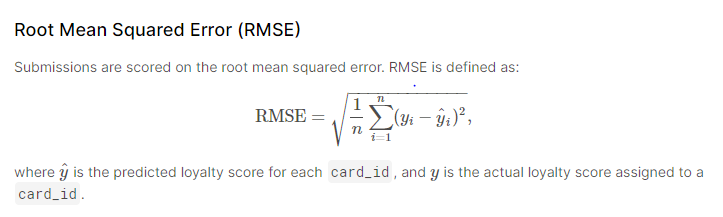

In [10]:
from IPython.display import Image
Image("C:\\Users\\Narender Nani\\Downloads\\AAIC\\AAIC\\Solved assignments\\self case study1\\submission\\elo_RMSE.PNG")

### 1.4. Credits: <br>

##### EDA, featurization and Model building
1. https://www.kaggle.com/batalov/making-sense-of-elo-data-eda
2. https://github.com/alvarorgaz/Kaggle-Elo-Merchant-Category-Recommendation/blob/master/0.%20Data%20Dictionary.xlsx
3. https://www.kaggle.com/roydatascience/elo-stack-with-goss-boosting


##### Platform:
1. https://colab.research.google.com/

# 2. Data description:

### 2.1 Import Libraries

In [0]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import gc
import pickle
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
from scipy.stats import chi2_contingency
import seaborn as sns
from datetime import datetime, date
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
gc.collect()

4

In [0]:
#Add All the Models Libraries

# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [0]:
#Using Kaggle datasets in Colab
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c elo-merchant-category-recommendation

In [0]:
#Extract zip files
import zipfile
for file in ['/content/sample_submission.csv.zip','/content/historical_transactions.csv.zip','/content/train.csv.zip','/content/test.csv.zip', '/content/new_merchant_transactions.csv.zip', '/content/merchants.csv.zip' ]:
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [0]:
# to make this notebook's output stable across runs
np.random.seed(123)
gc.collect()
# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

4

In [0]:
#Reduce the memory usage - Inspired by Panchajanya Banerjee
#determine and apply the smallest data type that can fit the range of values
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    '''
    Reduce the memory usage by applying the smallest data type that can fit the range of values
    '''
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
#https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas
def cat_corr(df):
  '''
  Check correlation between categorical features using chi-square measure
  '''
  cat = df.select_dtypes('category')
  df=cat.apply(lambda x : pd.factorize(x)[0])+1
  corr = pd.DataFrame([chisquare(df[x].values,f_exp=df.values.T,axis=1)[0] for x in df], columns= df.columns, index = df.columns)
  normalized_df=np.round((corr-corr.min())/(corr.max()-corr.min()), 3)
  plt.subplots(figsize=(10,8))
  return sns.heatmap(normalized_df, annot=True)

### 2.2 Data overview

The problem has 5 datasets/files

* **train.csv** : it has 6 features, first_active_month, card-id, feature1, feature2, feature3 and target

* **Test.csv** : the test set has same features as train set without targets

* **historical_transactions.csv** : up to 3 months' worth of historical transactions for each card_id

* **merchants.csv** : additional information about all merchants / merchant_ids in the dataset.

* **new_merchant_transactions.csv** : two months' worth of data for each card_id containing ALL purchases that card_id 
made at merchant_ids that were not visited in the historical data

* **sample_submission.csv** : a sample submission file in the correct format - contains all card_ids you are expected to predict for.

Data contains numerical and categorical features and there are no text features

### 2.3 Loading data

In [0]:
%%time
# Loading train and test data
train = reduce_mem_usage(pd.read_csv('/content/train.csv',parse_dates=["first_active_month"] ))
test = reduce_mem_usage(pd.read_csv('/content/test.csv', parse_dates=["first_active_month"]))

# Loading merchants data
merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv'))

# replacing inf values with nan
merchants.replace([-np.inf, np.inf], np.nan, inplace=True)

#Loading data new_merchant_transactions
new_transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv'))
new_transactions.replace([-np.inf, np.inf], np.nan, inplace=True)


# Loading historical_transactions data
transactions = reduce_mem_usage(pd.read_csv('../content/historical_transactions.csv'))
transactions.replace([-np.inf, np.inf], np.nan, inplace=True)

gc.collect()

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 30.32 Mb (46.0% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
CPU times: user 1min 47s, sys: 13.6 s, total: 2min
Wall time: 2min 14s


In [0]:
# Replacing nan
merchants['category_2'].fillna(1,inplace=True)
merchants['merchant_id'].fillna('M_ID_838061e48c',inplace=True)

transactions['category_2'].fillna(1,inplace=True)
transactions['category_3'].fillna('A',inplace=True)
transactions['merchant_id'].fillna('M_ID_838061e48c',inplace=True)

new_transactions['category_2'].fillna(1,inplace=True)
new_transactions['category_3'].fillna('A',inplace=True)
new_transactions['merchant_id'].fillna('M_ID_838061e48c',inplace=True)

In [0]:
%%time
# change data types to Category for correlation analysis
features_cat = [ 'merchant_category_id', 'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range','feature_1', 'feature_2', 'feature_3'
       'category_4', 'city_id', 'state_id', 'category_2', 'authorized_flag',
       'category_3', 'month_lag', 'active_months_lag3', 'active_months_lag6', 'active_months_lag12']
for col in features_cat:
  if col in merchants.columns:
    merchants[col] = merchants[col].astype('category')
for col in features_cat:
  if col in transactions.columns:
    transactions[col] = transactions[col].astype('category')
for col in features_cat:
  if col in new_transactions.columns:
    new_transactions[col] = new_transactions[col].astype('category')
for col in features_cat:
  if col in train.columns:
    train[col] = train[col].astype('category')
for col in features_cat:
  if col in test.columns:
    test[col] = test[col].astype('category')

CPU times: user 11 s, sys: 374 ms, total: 11.4 s
Wall time: 11.4 s


# 3. Exploratory Data Analysis </h1>

## 3.1 EDA on test.csv and train.csv.

train.csv and test.csv column descriptions:

**card_id:**	Unique card identifier

**first_active_month:**	 'YYYY-MM', month of first purchase

**feature_1:**	Anonymized card categorical feature

**feature_2:**	Anonymized card categorical feature

**feature_3:**	Anonymized card categorical feature

**target:** Loyalty numerical score calculated 2 months after historical and evaluation period!

Well, that's not very informative. Let's look at the sizes of these tables:

### 3.1.1 Data overview of train.csv

In [0]:
print("Nº of observations and features:")
train.shape
print("First observations:")
train.head()
print("Python features dtypes:")
train.dtypes
print("Unique values by features:")
train.nunique(dropna=False,axis=0)
print("Missing values by features:")
train.isnull().sum(axis=0)

Nº of observations and features:


(201917, 6)

First observations:


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159790


Python features dtypes:


first_active_month    datetime64[ns]
card_id                       object
feature_1                       int8
feature_2                       int8
feature_3                       int8
target                       float16
dtype: object

Unique values by features:


first_active_month        75
card_id               201917
feature_1                  5
feature_2                  3
feature_3                  2
target                 19435
dtype: int64

Missing values by features:


first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

We can see that there are:
- 1 feature type ID: *card_id*
- 1 feature type numerical: *target*
- 1 feature type date: *first_active_month*
- 3 features type categorical: *feature_1*, *feature_2*, *feature_3*

Let's see basic statistics of numerical features and levels distribution of categorical.

In [0]:
train[["target"]].describe()
train.groupby("feature_1").size()
train.groupby("feature_2").size()
train.groupby("feature_3").size()

,target
count,201917.000000
mean,NaN
std,0.000000
min,-33.218750
25%,-0.883301
50%,-0.023438
75%,0.765625
max,17.968750


feature_1
1    12037
2    55797
3    73573
4    19885
5    40625
dtype: int64

feature_2
1    89242
2    74839
3    37836
dtype: int64

feature_3
0     87719
1    114198
dtype: int64

### 3.1.2 Data overview of test.csv

In [0]:
print("Nº of observations and features:")
test.shape
print("First observations:")
test.head()
print("Python features dtypes:")
test.dtypes
print("Unique values by features:")
test.nunique(dropna=False,axis=0)
print("Missing values by features:")
test.isnull().sum(axis=0)

Nº of observations and features:


(123623, 5)

First observations:


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


Python features dtypes:


first_active_month    datetime64[ns]
card_id                       object
feature_1                       int8
feature_2                       int8
feature_3                       int8
dtype: object

Unique values by features:


first_active_month        76
card_id               123623
feature_1                  5
feature_2                  3
feature_3                  2
dtype: int64

Missing values by features:


first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

We can see that there are:
- 1 feature type ID: *card_id*
- 1 feature type date: *first_active_month*
- 3 features type categorical: *feature_1*, *feature_2*, *feature_3*

Let's see basic statistics of numerical features and levels distribution of categorical.

In [0]:
test.groupby("feature_1").size()
test.groupby("feature_2").size()
test.groupby("feature_3").size()

feature_1
1     7406
2    34115
3    44719
4    12332
5    25051
dtype: int64

feature_2
1    54775
2    45993
3    22855
dtype: int64

feature_3
0    53853
1    69770
dtype: int64

### 3.1.3 Feature distributions in train.csv and test.csv

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.1, 'Feature distributions in train.csv and test.csv')

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'feature_1')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'feature_2')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'feature_3')

(array([2.2070e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        4.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 8.0000e+00, 6.0000e+00, 5.0000e+00,
        2.3000e+01, 2.5000e+01, 2.5000e+01, 5.0000e+01, 8.6000e+01,
        9.7000e+01, 1.5300e+02, 2.6700e+02, 3.9900e+02, 5.8700e+02,
        9.0300e+02, 1.2440e+03, 1.8230e+03, 2.7170e+03, 4.0000e+03,
        6.2560e+03, 9.8870e+03, 1.6055e+04, 2.4794e+04, 3.6618e+04,
        3.3088e+04, 2.2380e+04, 1.3553e+04, 8.4080e+03, 5.3450e+03,
        3.5770e+03, 2.3810e+03, 1.6030e+03, 1.03

Text(0.5, 1.0, 'target')

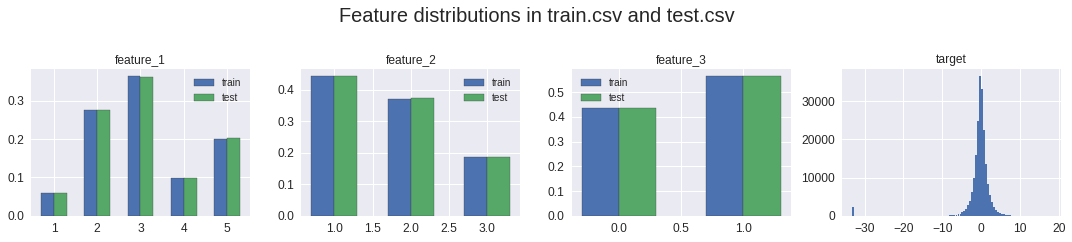

In [0]:
%matplotlib inline
#Comparing Feature distributions in train & test Data

plt.figure(figsize=[15,5])
plt.suptitle('Feature distributions in train.csv and test.csv', fontsize=20, y=1.1)
for num, col in enumerate(['feature_1', 'feature_2', 'feature_3', 'target']):
    plt.subplot(2, 4, num+1)
    if col is not 'target':
        v_c = train[col].value_counts() / train.shape[0]
        plt.bar(v_c.index, v_c, label=('train'), align='edge', width=-0.3, edgecolor=[0.2]*3)
        v_c = test[col].value_counts() / test.shape[0]
        plt.bar(v_c.index, v_c, label=('test'), align='edge', width=0.3, edgecolor=[0.2]*3)
        plt.title(col)
        plt.legend()
    else:
        plt.hist(train[col], bins = 100) # Histogram of target variable
        plt.title(col)
    plt.tight_layout()
plt.tight_layout()
plt.show()

#### Observation: 
We can see from above plots that test and train data are distributed similarly. Additionally, there are some outliers in the target column.

### 3.1.4: Outlier vs. non-outlier feature distributions

2207 outliers found (target < -30)


<Figure size 720x360 with 0 Axes>

Text(0.5, 1.1, 'Outlier vs. non-outlier feature distributions')

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'feature_1')

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'feature_2')

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'feature_3')

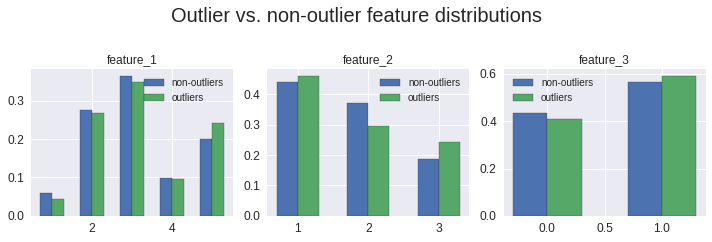

In [0]:
# Separating outliers and non_outliers features in Target and plotting
outliers = train.loc[train['target'] < -30]
non_outliers = train.loc[train['target'] >= -30]
print('{:d} outliers found (target < -30)'.format(outliers.shape[0]))

#Outlier vs. non-outlier feature distributions
plt.figure(figsize=[10,5])
plt.suptitle('Outlier vs. non-outlier feature distributions', fontsize=20, y=1.1)

for num, col in enumerate(['feature_1', 'feature_2', 'feature_3', 'target']):
    if col is not 'target':
        plt.subplot(2, 3, num+1)
        v_c = non_outliers[col].value_counts() / non_outliers.shape[0]
        plt.bar(v_c.index, v_c, label=('non-outliers'), align='edge', width=-0.3, edgecolor=[0.2]*3)
        v_c = outliers[col].value_counts() / outliers.shape[0]
        plt.bar(v_c.index, v_c, label=('outliers'), align='edge', width=0.3, edgecolor=[0.2]*3)
        plt.title(col)
        plt.legend()

plt.tight_layout()
plt.show()

#### Observation: 
We can see There are some slignt differences between outliers and non-outliers, but they don't seem to be that big and they certainly can't explain the difference between the target values,  at least based on the features in the train dataset. It's probably a good idea to remove them, unless we can find differences between outliers and non-outliers in other tables that will allow us to detect them.

### 3.1.5:  Correlation coefficients for all variables

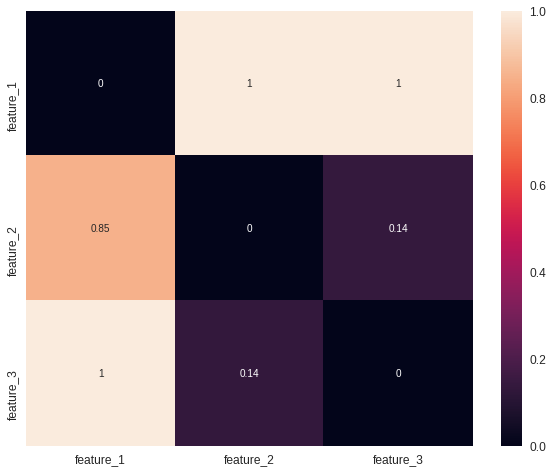

In [0]:
#Correlation coefficients for all categorical variables in train.csv
train['feature_3'] = train['feature_3'].astype('category')
test['feature_3'] = test['feature_3'].astype('category')
cat_corr(train)

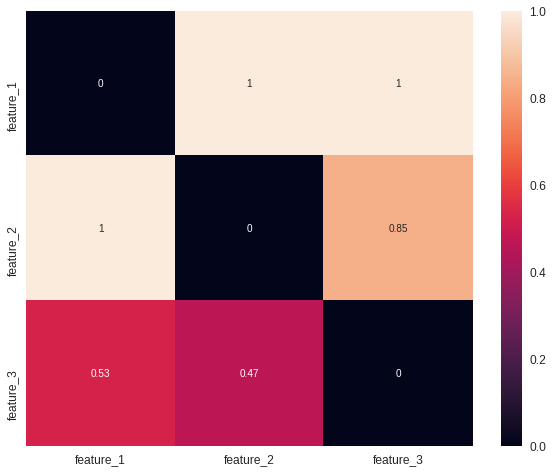

In [0]:
#Correlation coefficients for categorical variables in train.csv
cat_corr(test)

#### Observation: 
1. why the matrix is asymmetrical : https://cran.r-project.org/web/packages/GoodmanKruskal/vignettes/GoodmanKruskal.html

2. We can see that in train except feature 2 and fature 3 others features are highly correlated.

3. In test all are highly correlated except feature 2 and 3 which are failry correlated

### 3.1.6: scatter plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea56a05978>,
      dtype=object)

Text(0.5, 0.98, 'Pair-wise scatter plots for columns in train.csv')

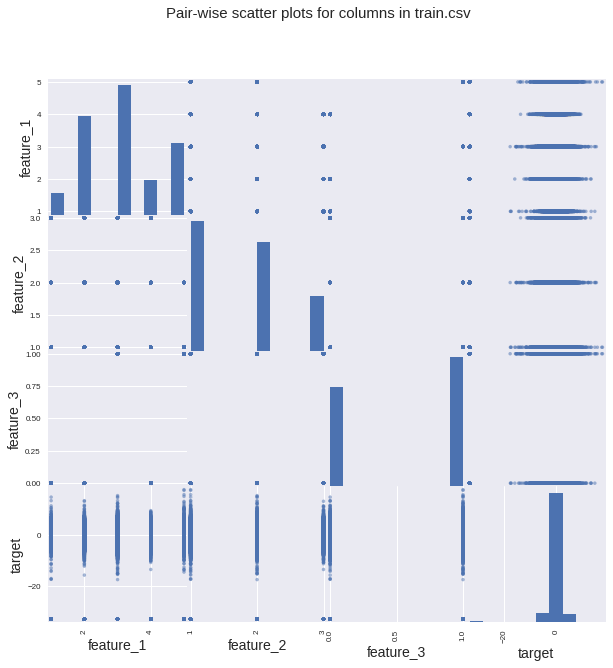

In [0]:
#Pair-wise scatter plots for columns in train.csv
from pandas.plotting import scatter_matrix
select_cols = ['feature_1', 'feature_2', 'feature_3', 'target']
scatter_matrix(train[select_cols], figsize=[10,10])
plt.suptitle('Pair-wise scatter plots for columns in train.csv', fontsize=15)
plt.show()

Observation: 
Thers is not a lot of useful information but we can see different target variances for different values of the feature_1 , but it's most likely due to the different amount of data corresponding to each feature.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea56a05828>,
      dtype=object)

Text(0.5, 0.98, 'Pair-wise scatter plots for columns in test.csv')

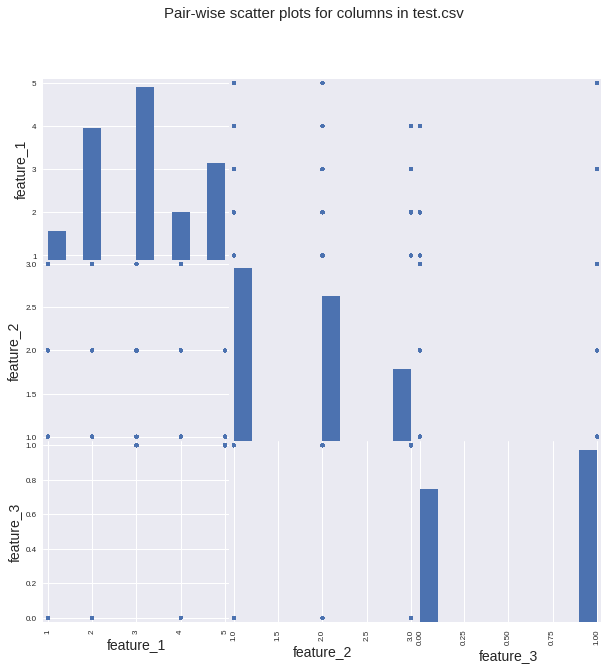

In [0]:
#Pair-wise scatter plots for columns in test.csv
from pandas.plotting import scatter_matrix
select_cols = ['feature_1', 'feature_2', 'feature_3']
scatter_matrix(test[select_cols], figsize=[10,10])
plt.suptitle('Pair-wise scatter plots for columns in test.csv', fontsize=15)
plt.show()

## 3.2 EDA on merchants.csv.


From the dataset's describtion:

**merchant_id:**	Unique merchant identifier

**merchant_group_id:**	Merchant group (anonymized )

**merchant_category_id:**	Unique identifier for merchant category (anonymized )

**subsector_id:**	Merchant category group (anonymized )

**numerical_1:**	anonymized measure

**numerical_2:**	anonymized measure

**category_1:**	anonymized category

**most_recent_sales_range:**	Range of revenue (monetary units) in last active month --> A > B > C > D > E

**most_recent_purchases_range:**	Range of quantity of transactions in last active month --> A > B > C > D > E

**avg_sales_lag3:**	Monthly average of revenue in last 3 months divided by revenue in last active month

**avg_purchases_lag3:**	Monthly average of transactions in last 3 months divided by transactions in last active 
month

**active_months_lag3:**	Quantity of active months within last 3 months

**avg_sales_lag6:**	Monthly average of revenue in last 6 months divided by revenue in last active month

**avg_purchases_lag6:**	Monthly average of transactions in last 6 months divided by transactions in last active 
month

**active_months_lag6:**	Quantity of active months within last 6 months

**avg_sales_lag12:**	Monthly average of revenue in last 12 months divided by revenue in last active month

**avg_purchases_lag12:**	Monthly average of transactions in last 12 months divided by transactions in last active month

**active_months_lag12:**	Quantity of active months within last 12 months

**category_4:**	anonymized category

**city_id:**	City identifier (anonymized )

**state_id:**	State identifier (anonymized )

**category_2:**	anonymized category!

### 3.2.1 Data overview on merchants.csv

In [0]:
print("Nº of observations and features:")
merchants.shape
print("First observations:")
merchants.head()
print("Python features dtypes:")
merchants.dtypes
print("Unique values by features:")
merchants.nunique(dropna=False,axis=0)
print("Missing values by features:")
merchants.isnull().sum(axis=0)

Nº of observations and features:


(334696, 22)

First observations:


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,9.666667,3,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,1.750000,3,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,260.000000,2,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


Python features dtypes:


merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
numerical_1                    float16
numerical_2                    float16
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float32
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float32
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float32
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float16
dtype: object

Unique values by features:


merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
numerical_1                       950
numerical_2                       944
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
avg_sales_lag3                   3373
avg_purchases_lag3             100003
active_months_lag3                  3
avg_sales_lag6                   4508
avg_purchases_lag6             135202
active_months_lag6                  6
avg_sales_lag12                  5010
avg_purchases_lag12            172917
active_months_lag12                12
category_4                          2
city_id                           271
state_id                           25
category_2                          6
dtype: int64

Missing values by features:


merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 3
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 3
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                3
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

We can see that there are:
- 6 features type ID: *merchant_id*, *merchant_group_id*, *merchant_category_id*, *subsector_id*, *city_id*, *state_id*
- 3 features type integer/counter: *active_months_lag3*, *active_months_lag6*, *active_months_lag12*
- 8 feature type numerical: *numerical_1*, *numerical_2*, *avg_sales_lag3*, *avg_purchases_lag3*, *avg_sales_lag6*, *avg_purchases_lag6*, *avg_sales_lag12*, *avg_purchases_lag12*
- 5 features type categorical: *category_1*, *most_recent_sales_range*, *most_recent_purchases_range*, *category_4*,*category_4*

Let's see basic statistics of numerical features and levels distribution of categorical.

In [0]:
merchants[["active_months_lag3","active_months_lag6","active_months_lag12","numerical_1","numerical_2",
          "avg_sales_lag3","avg_purchases_lag3","avg_sales_lag6","avg_purchases_lag6","avg_sales_lag12",
          "avg_purchases_lag12"]].describe()
merchants.groupby("most_recent_sales_range").size()
merchants.groupby("most_recent_purchases_range").size()
merchants.groupby("category_1").size()
merchants.groupby("category_2").size()
merchants.groupby("category_4").size()

,active_months_lag3,active_months_lag6,active_months_lag12,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,avg_sales_lag6,avg_purchases_lag6,avg_sales_lag12,avg_purchases_lag12
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,334693.000000,3.346830e+05,334693.000000,3.346830e+05,334693.000000
mean,2.994108,5.947397,11.599335,0.011482,0.008095,13.839176,1.590762,2.165529e+01,1.887568,2.523122e+01,2.079195
std,0.095247,0.394936,1.520138,0.000000,0.000000,2395.453369,107.187059,3.947046e+03,97.862790,5.251777e+03,88.442384
min,1.000000,1.000000,1.000000,-0.057465,-0.057465,-82.129997,0.333495,-8.213000e+01,0.167045,-8.213000e+01,0.098330
25%,3.000000,6.000000,12.000000,-0.057465,-0.057465,0.880000,0.923650,8.500000e-01,0.902245,8.500000e-01,0.898333
50%,3.000000,6.000000,12.000000,-0.057465,-0.057465,1.000000,1.016667,1.010000e+00,1.026961,1.020000e+00,1.043360
75%,3.000000,6.000000,12.000000,-0.047546,-0.047546,1.160000,1.146520,1.230000e+00,1.215556,1.290000e+00,1.266461
max,3.000000,6.000000,12.000000,183.750000,182.125000,851844.625000,61851.333333,1.513959e+06,56077.500000,2.567408e+06,50215.555556


most_recent_sales_range
A      1005
B      5037
C     34075
D    117475
E    177104
dtype: int64

most_recent_purchases_range
A      1010
B      5046
C     34144
D    119187
E    175309
dtype: int64

category_1
N    327657
Y      7039
dtype: int64

category_2
1.0    160888
2.0     20661
3.0     51887
4.0     36450
5.0     52923
dtype: int64

category_4
N    238596
Y     96100
dtype: int64

### 3.2.2 fixing outliers in merchants

In [0]:
# Several columns in merchants.csv have outliers that squeeze most of the data into one bin
# Let's fix that by removing those outliers:
clean_merchants = merchants.loc[(merchants['numerical_1'] < 0.1) &
                               (merchants['numerical_2'] < 0.1) &
                               (merchants['avg_sales_lag3'] < 5) &
                               (merchants['avg_purchases_lag3'] < 5) &
                               (merchants['avg_sales_lag6'] < 10) &
                               (merchants['avg_purchases_lag6'] < 10) &
                               (merchants['avg_sales_lag12'] < 10) &
                               (merchants['avg_purchases_lag12'] < 10)]

### 3.2.3 Analysis using Histograms

<Figure size 1080x1080 with 0 Axes>

Text(0.5, 1.02, 'Merchants table histograms')

<BarContainer object of 12 artists>

Text(0.5, 1.0, 'active_months_lag12')

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'active_months_lag3')

<BarContainer object of 6 artists>

Text(0.5, 1.0, 'active_months_lag6')

Text(0.5, 1.0, 'avg_purchases_lag12')

Text(0.5, 1.0, 'avg_purchases_lag3')

Text(0.5, 1.0, 'avg_purchases_lag6')

Text(0.5, 1.0, 'avg_sales_lag12')

Text(0.5, 1.0, 'avg_sales_lag3')

Text(0.5, 1.0, 'avg_sales_lag6')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'category_1')

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'category_2')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'category_4')

Text(0.5, 1.0, 'merchant_category_id')

Text(0.5, 1.0, 'merchant_group_id')

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'most_recent_purchases_range')

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'most_recent_sales_range')

Text(0.5, 1.0, 'numerical_1')

Text(0.5, 1.0, 'numerical_2')

Text(0.5, 1.0, 'subsector_id')

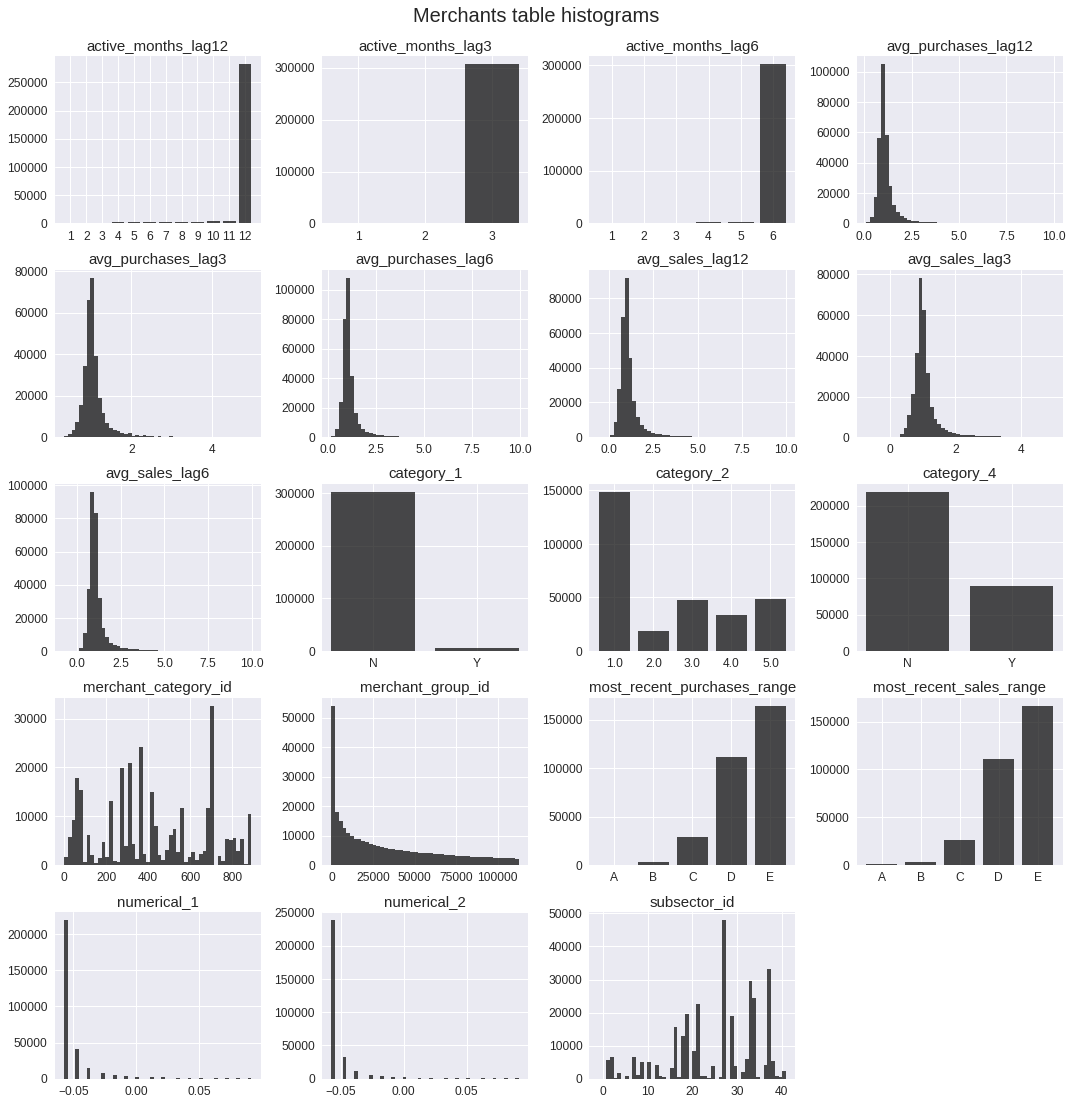

In [0]:
#Merchants column histograms:

cat_cols = ['active_months_lag6','active_months_lag3','most_recent_sales_range', 'most_recent_purchases_range','category_1','active_months_lag12','category_4', 'category_2']
num_cols = ['numerical_1', 'numerical_2','merchant_group_id','merchant_category_id','avg_sales_lag3', 'avg_purchases_lag3', 'subsector_id', 'avg_sales_lag6', 'avg_purchases_lag6', 'avg_sales_lag12', 'avg_purchases_lag12']

plt.figure(figsize=[15, 15])
plt.suptitle('Merchants table histograms', y=1.02, fontsize=20)
ncols = 4
nrows = int(np.ceil((len(cat_cols) + len(num_cols))/4))
last_ind = 0
for col in sorted(list(clean_merchants.columns)):
    #print('processing column ' + col)
    if col in cat_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = clean_merchants[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color=(0, 0, 0, 0.7))
        plt.title(col, fontsize=15)
    if col in num_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        clean_merchants[col].hist(bins = 50, color=(0, 0, 0, 0.7))
        plt.title(col, fontsize=15)
    plt.tight_layout()

#### Observations:
* Looks like merchant_group_ids, numerical_1 and numerical_2 are sorted in the descending order
* and Most recent purchase range and sales range are sorted in ascendig order
* match_category_id and subsector_id are not sorted
* numerical_1 and numerical_2 (ironically) seem to represent more of a categorical value as they take a discrete set of values

In [0]:
# converting category names to numbers, so these columns
# can participate in the correlation coefficient heat map
clean_merchants['most_recent_purchases_range'].replace({'A':4, 'B':3, 'C':2, 'D':1, 'E':0}, inplace=True)
clean_merchants['most_recent_sales_range'].replace({'A':4, 'B':3, 'C':2, 'D':1, 'E':0}, inplace=True)
clean_merchants['category_1'].replace({'N':0, 'Y':1}, inplace=True)

### 3.2.4 correlations between columns in merchants

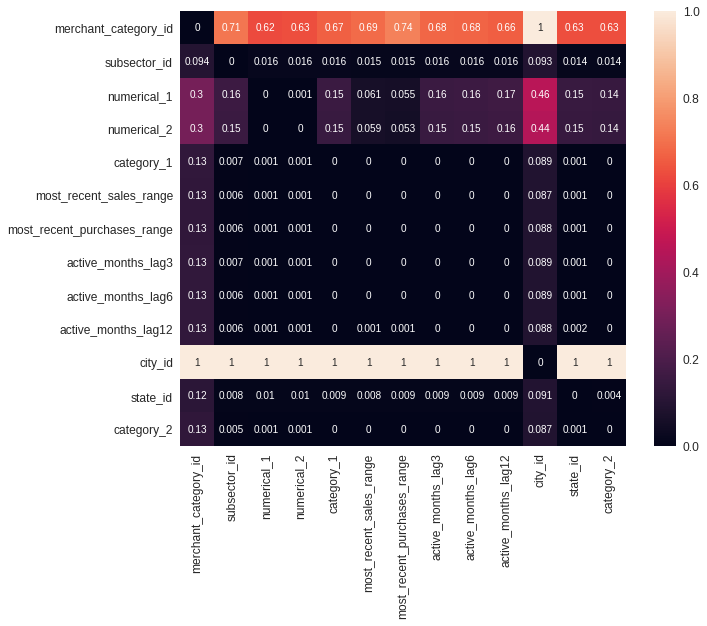

In [0]:
# correlations between columns in merchants.csv:
cat_corr(merchants)

#### Observations:
1. Merchant_category_id and city_id's are highly correlated with all the other features
2. numerical 1 and numercal 2 are fairly correlated with other features

### 3.2.5 scatter_matrix of clean_merchants

#### Group 1:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9d74b1588>,
      dtype=object)

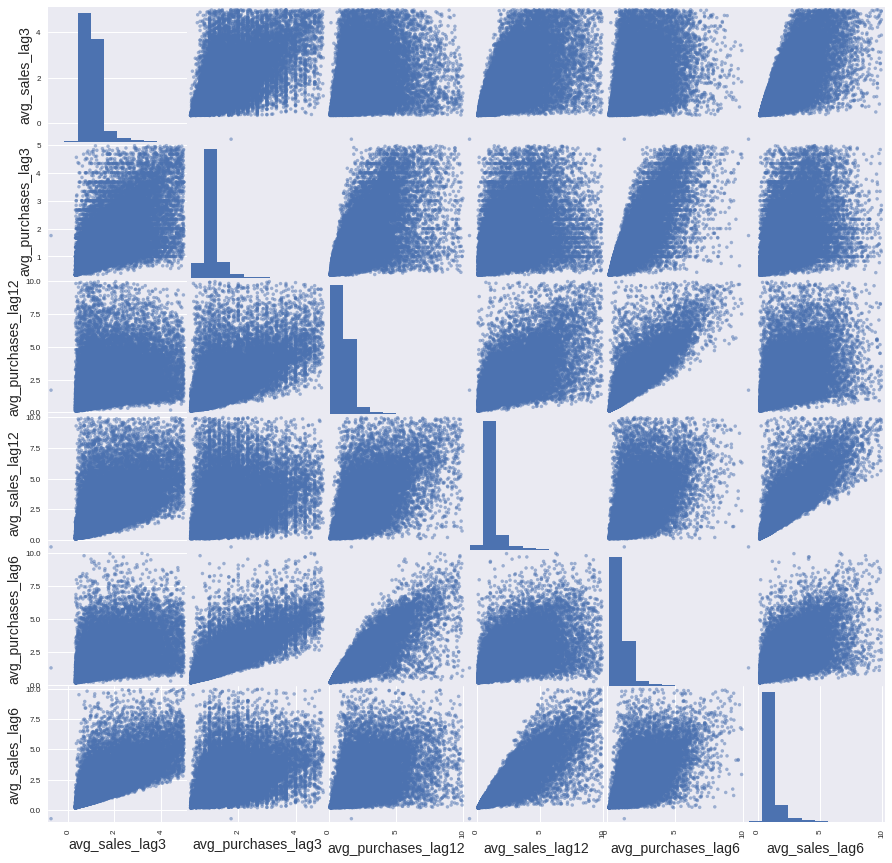

In [0]:
scatter_matrix(clean_merchants[ordered_cols[-6:]], figsize=[15,15])
plt.show()

#### Observations:
Looks like regular coorelated values. One interesting thing to look at is the average sales and purchases within the last 3, 6, and 12 months:


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'Avergage sales and number of purchases\nover the last 12, 6, and 3 months')

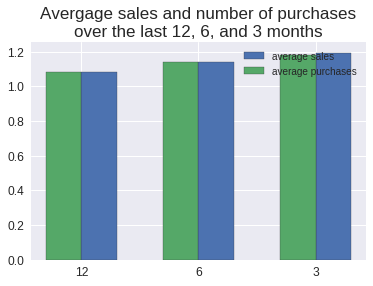

In [0]:
#Avergage sales and number of purchases over the last 12, 6, and 3 months
x = np.array([12, 6, 3]).astype(str)
sales_rates = clean_merchants[['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']].mean().values
purchase_rates = clean_merchants[['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']].mean().values
plt.bar(x, sales_rates, width=0.3, align='edge', label='average sales', edgecolor=[0.2]*3)
plt.bar(x, purchase_rates, width=-0.3, align='edge', label='average purchases', edgecolor=[0.2]*3)
plt.legend()
plt.title('Avergage sales and number of purchases\nover the last 12, 6, and 3 months', fontsize=17)
plt.show()

#### Observations :
It seems like businesses' sales grow over time, which is good.

#### Group 2:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9d4531400>,
      dtype=object)

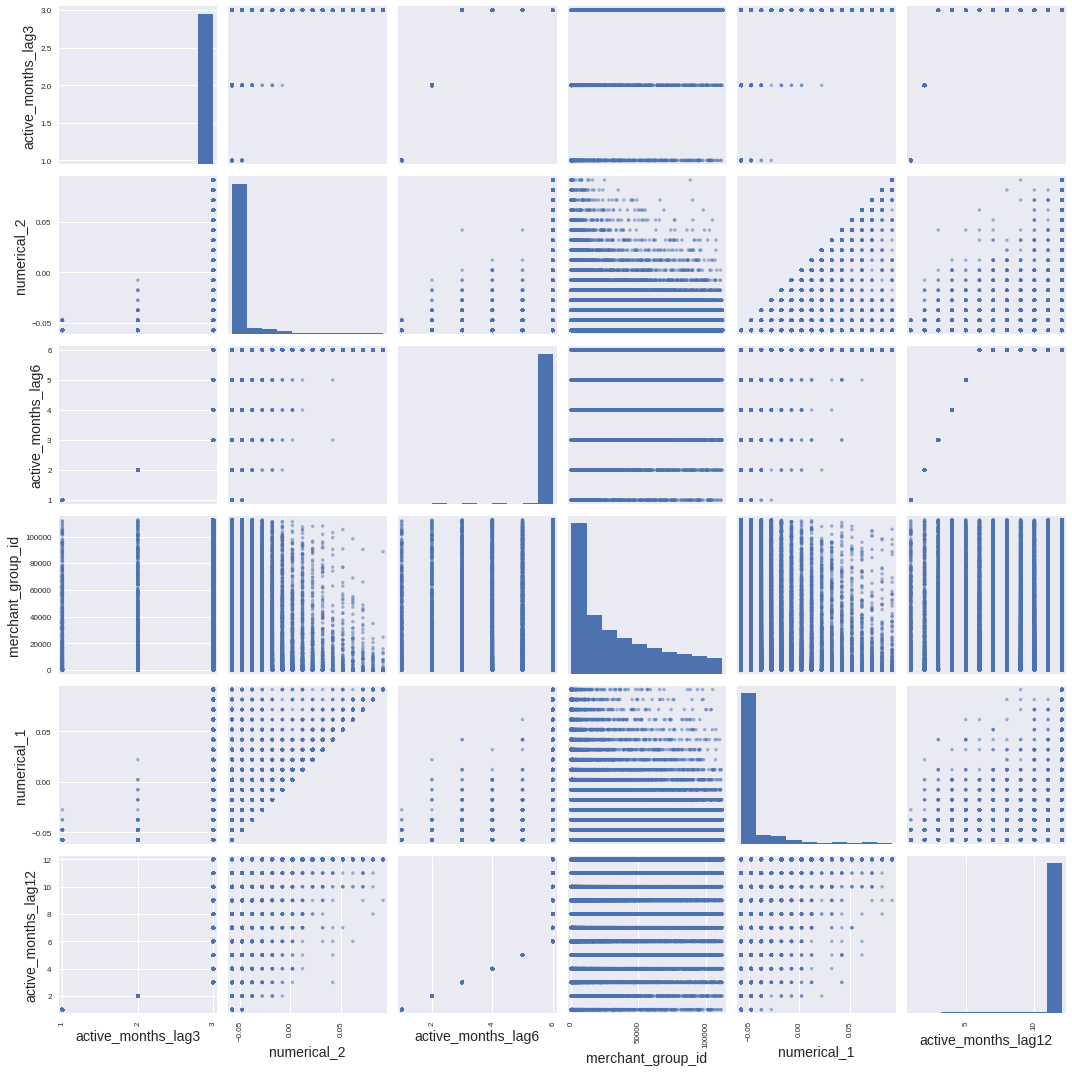

In [0]:
scatter_matrix(clean_merchants[ordered_cols[-14:-8]], figsize=[15,15])
plt.tight_layout()
plt.show()

Now, this is interesting.
* numerical_1 serves as the upper limit for numerical_2. 
* both numerical_1 and numerical_2 increase with the amount of active months
* active_months_lag 3 and 6 are basically truncated versions of active_months_12, so they can be dropped. 
* It seems that the merchants with less than 12 active months are the ones that only recently opened their business. I don't see any merchants that ran out of business (they would show higher lag12 values compared to the lag6 and lag3 when lag6 < 6 and lag3 < 3)

#### Group 3:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9d3a76ef0>,
      dtype=object)

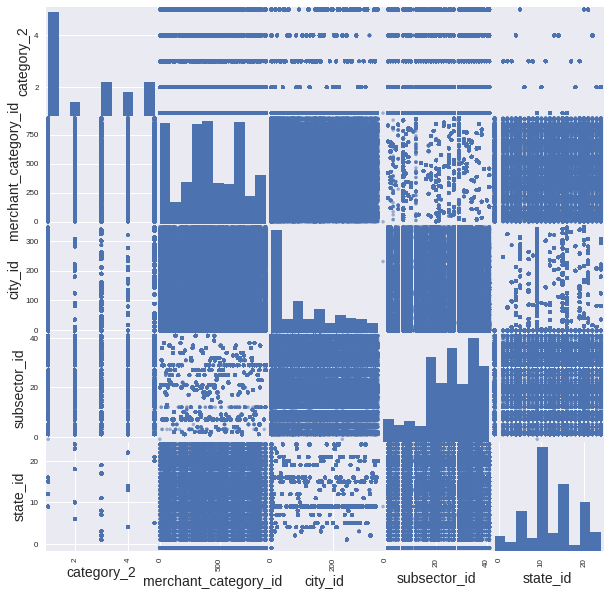

In [0]:
scatter_matrix(merchants[ordered_cols[0:6]], figsize=[10,10])
plt.show()

#### Onservation : 
there is not much interesting in this last group.

## 3.3 EDA on new_merchants_transactions.csv

Let's look at the new merchants' transactions. "New" here means new for the customer, i.e. the customer has never purchased anything from those vendors during the period corresponding to the data in historical_transactions.csv.

**Dataset description:**

**card_id:**	Card identifier

**month_lag:**	month lag to reference date

**purchase_date:**	Purchase date

**authorized_flag:**	Y' if approved, 'N' if denied

**category_3:**	anonymized category

**installments:**	number of installments of purchase

**category_1:**	anonymized category

**merchant_category_id:**	Merchant category identifier (anonymized )

**subsector_id:**	Merchant category group identifier (anonymized )

**merchant_id:**	Merchant identifier (anonymized)

**purchase_amount:**	Normalized purchase amount

**city_id:**	City identifier (anonymized )

**state_id:**	State identifier (anonymized )

**category_2:**	anonymized category

In [0]:
# converting purchase time string into datetime
from datetime import datetime
new_transactions['purchase_date'] = new_transactions['purchase_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

### 3.3.1 Data overview of new_merchant_transactions.csv

In [0]:
print("Nº of observations and features:")
new_transactions.shape
print("First observations:")
new_transactions.head()
print("Python features dtypes:")
new_transactions.dtypes
print("Unique values by features:")
new_transactions.nunique(dropna=False,axis=0)
print("Missing values by features:")
new_transactions.isnull().sum(axis=0)

Nº of observations and features:


(1963031, 14)

First observations:


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


Python features dtypes:


authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float16
purchase_date           datetime64[ns]
category_2                     float16
state_id                         int64
subsector_id                     int64
dtype: object

Unique values by features:


authorized_flag               1
card_id                  290001
city_id                     308
category_1                    2
installments                 15
category_3                    4
merchant_category_id        314
merchant_id              226130
month_lag                     2
purchase_amount           15014
purchase_date           1667025
category_2                    6
state_id                     25
subsector_id                 41
dtype: int64

Missing values by features:


authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

We can see that there are:
- 6 features type ID: *card_id*, *merchant_category_id*, *subsector_id*, *merchant_id*, *city_id*, *state_id*
- 2 features type integer/counter: *month_lag*, *installments*
- 1 feature type numerical: *purchase_amount*
- 1 feature type date: *purchase_date*
- 4 features type categorical: *authorized_flag*, *category_3*, *category_1*, *category_2*

Let's see basic statistics of numerical features and levels distribution of categorical.

In [0]:
new_transactions[["month_lag","installments","purchase_amount"]].describe()
new_transactions.groupby("category_1").size()
new_transactions.groupby("category_2").size()
new_transactions.groupby("category_3").size()
new_transactions.groupby("authorized_flag").size()

,month_lag,installments,purchase_amount
count,1.963031e+06,1.963031e+06,1.963031e+06
mean,1.476515e+00,6.829643e-01,NaN
std,4.994483e-01,1.584069e+00,NaN
min,1.000000e+00,-1.000000e+00,-7.470703e-01
25%,1.000000e+00,0.000000e+00,-7.167969e-01
50%,1.000000e+00,1.000000e+00,-6.748047e-01
75%,2.000000e+00,1.000000e+00,-5.815430e-01
max,2.000000e+00,9.990000e+02,2.632500e+02


category_1
N    1899935
Y      63096
dtype: int64

category_2
1.0    1058242
2.0      65663
3.0     289525
4.0     178590
5.0     259266
dtype: int64

category_3
A    922244
B    836178
C    148687
dtype: int64

authorized_flag
Y    1963031
dtype: int64

### 3.3.2 Analysis using Histograms

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.02, 'New merchant transaction info')

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'authorized_flag')

([0], <a list of 1 Text xticklabel objects>)

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'category_1')

([0, 1], <a list of 2 Text xticklabel objects>)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'category_2')

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'category_3')

([0, 1, 2], <a list of 3 Text xticklabel objects>)

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'installments')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

Text(0.5, 1.0, 'merchant_category_id')

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000.]),
 <a list of 7 Text xticklabel objects>)

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'month_lag')

([0, 1], <a list of 2 Text xticklabel objects>)

Text(0.5, 1.0, 'purchase_amount')

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <a list of 6 Text xticklabel objects>)

Text(0.5, 1.0, 'purchase_date')

(array([736389., 736450., 736511., 736573., 736634., 736695., 736754.,
        736815.]), <a list of 8 Text xticklabel objects>)

<BarContainer object of 41 artists>

Text(0.5, 1.0, 'subsector_id')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 <a list of 41 Text xticklabel objects>)

Text(0.5, 1.0, 'subsector_id')

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

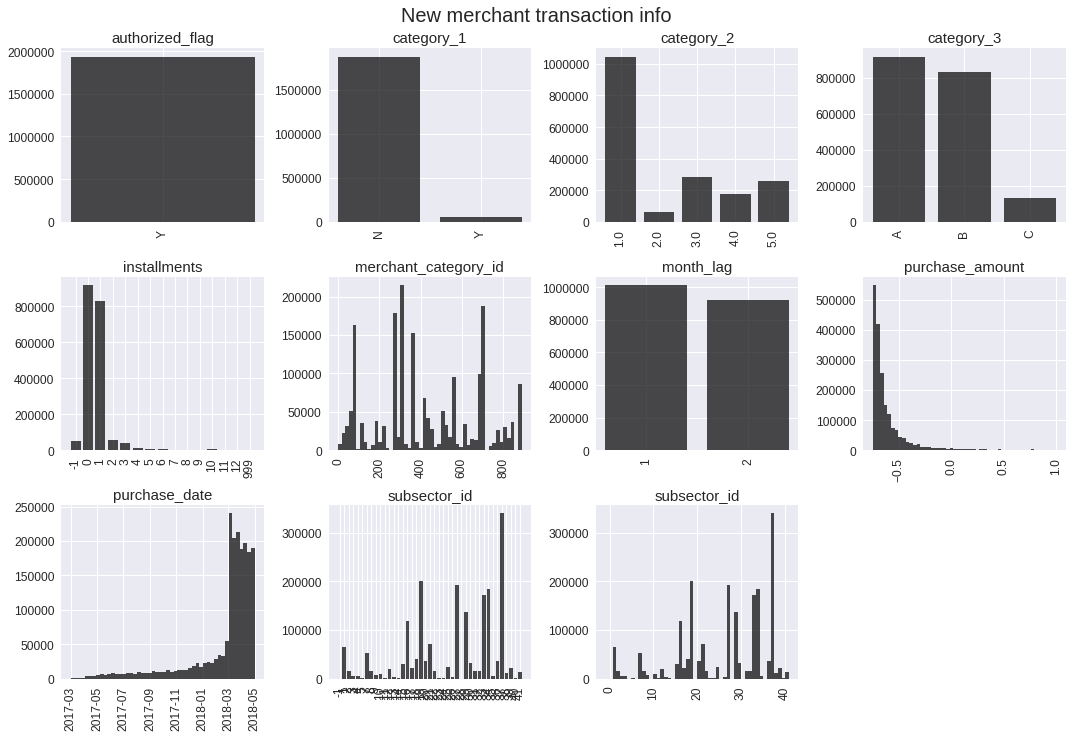

In [0]:
%matplotlib inline
# drawing histograms for each column of New merchant transaction
filtered_new_merch = new_transactions.loc[new_transactions['purchase_amount'] < 1]
cat_cols = ['authorized_flag', 'category_1', 'installments','category_3', 'month_lag','category_2', 'subsector_id']
num_cols = ['purchase_amount', 'purchase_date', 'merchant_category_id', 'subsector_id']

plt.figure(figsize=[15, 10])
plt.suptitle('New merchant transaction info', y=1.02, fontsize=20)
ncols = 4
nrows = int(np.ceil((len(cat_cols) + len(num_cols))/4))
last_ind = 0
for col in sorted(list(filtered_new_merch.columns)):
    #print('processing column ' + col)
    if col in cat_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = filtered_new_merch[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color=(0, 0, 0, 0.7))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    if col in num_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        filtered_new_merch[col].hist(bins = 50, color=(0, 0, 0, 0.7))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    plt.tight_layout()

#### Observations:
* All transactions in this table are authorized, so we can safely drop this column.
* Based on the purchase_date column, the reference date is different for different cards, but most of them are in February - March 2018.
* All purchases here were made within 2 months after the reference date

In [0]:
# converting category_1, category_3 and authorized_flag values to numeric ones, so we can use then in scatter plots and correlation coefficients
filtered_new_merch['category_3'].replace({'A':0, 'B':1, 'C':2}, inplace=True)
filtered_new_merch['category_1'].replace({'N':0, 'Y':1}, inplace=True)
filtered_new_merch['authorized_flag'].replace({'N':0, 'Y':1}, inplace=True)

### 3.3.3 correlations between columns in new_merchants

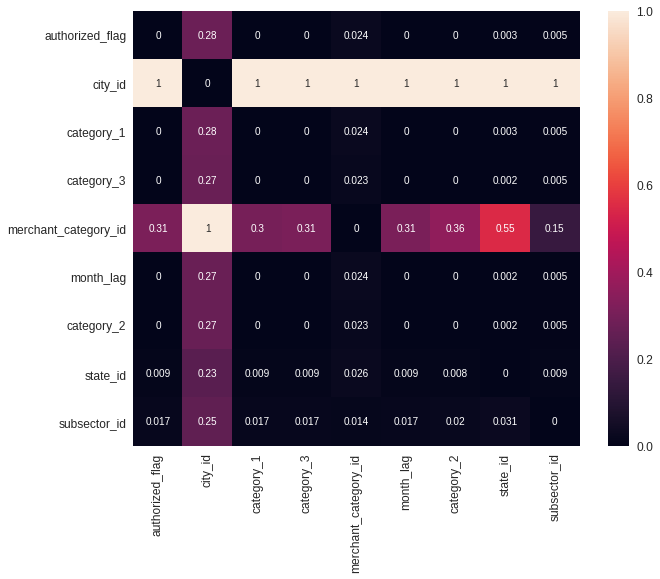

In [0]:
# correlations between columns in new_transactions.csv:
cat_corr(new_transactions)

#### Observations:
1. city_id's are highly correlated with all the other features
2. Merchant_catergory_id's are fairly correlated with other features

## 3.4 EDA on historical_transactions.csv
This table has exactly the same columns as the new merchant transactions:

### 3.4.1 Data overview of historical_transactions.csv

In [0]:
print("Nº of observations and features:")
transactions.shape
print("First observations:")
transactions.head()
print("Python features dtypes:")
transactions.dtypes
print("Unique values by features:")
transactions.nunique(dropna=False,axis=0)
print("Missing values by features:")
transactions.isnull().sum(axis=0)

Nº of observations and features:


(29112361, 14)

First observations:


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


Python features dtypes:


authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float32
purchase_date            object
category_2              float16
state_id                  int64
subsector_id              int64
dtype: object

Unique values by features:


We can see that there are:
- 6 features type ID: *card_id*, *merchant_category_id*, *subsector_id*, *merchant_id*, *city_id*, *state_id*
- 2 features type integer/counter: *month_lag*, *installments*
- 1 feature type numerical: *purchase_amount*
- 1 feature type date: *purchase_date*
- 4 features type categorical: *authorized_flag*, *category_3*, *category_1*, *category_2*

Let's see basic statistics of numerical features and levels distribution of categorical.

In [0]:
transactions[["month_lag","installments","month_lag","installments"]].describe()
transactions.groupby("authorized_flag").size()
transactions.groupby("category_3").size()
transactions.groupby("category_1").size()
transactions.groupby("category_2").size()

,month_lag,installments,month_lag,installments
count,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07
mean,-4.487294e+00,6.484954e-01,-4.487294e+00,6.484954e-01
std,3.588800e+00,2.795577e+00,3.588800e+00,2.795577e+00
min,-1.300000e+01,-1.000000e+00,-1.300000e+01,-1.000000e+00
25%,-7.000000e+00,0.000000e+00,-7.000000e+00,0.000000e+00
50%,-4.000000e+00,0.000000e+00,-4.000000e+00,0.000000e+00
75%,-2.000000e+00,1.000000e+00,-2.000000e+00,1.000000e+00
max,0.000000e+00,9.990000e+02,0.000000e+00,9.990000e+02


authorized_flag
N     2516909
Y    26595452
dtype: int64

category_3
A    15411747
B    11677522
C     1844933
dtype: int64

category_1
N    27028332
Y     2084029
dtype: int64

category_2
1.0    15177199
2.0     1026535
3.0     3911795
4.0     2618053
5.0     3725915
dtype: int64

### 3.4.2 Analysis using Histograms

In [0]:
transactions['purchase_date'] = transactions['purchase_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.02, 'Transaction history info')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'authorized_flag')

([0, 1], <a list of 2 Text xticklabel objects>)

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'category_1')

([0, 1], <a list of 2 Text xticklabel objects>)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'category_2')

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'category_3')

([0, 1, 2], <a list of 3 Text xticklabel objects>)

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'installments')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

Text(0.5, 1.0, 'merchant_category_id')

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000.]),
 <a list of 7 Text xticklabel objects>)

<BarContainer object of 14 artists>

Text(0.5, 1.0, 'month_lag')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text xticklabel objects>)

Text(0.5, 1.0, 'purchase_amount')

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <a list of 6 Text xticklabel objects>)

Text(0.5, 1.0, 'purchase_date')

(array([736330., 736389., 736450., 736511., 736573., 736634., 736695.,
        736754.]), <a list of 8 Text xticklabel objects>)

<BarContainer object of 41 artists>

Text(0.5, 1.0, 'subsector_id')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 <a list of 41 Text xticklabel objects>)

Text(0.5, 1.0, 'subsector_id')

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

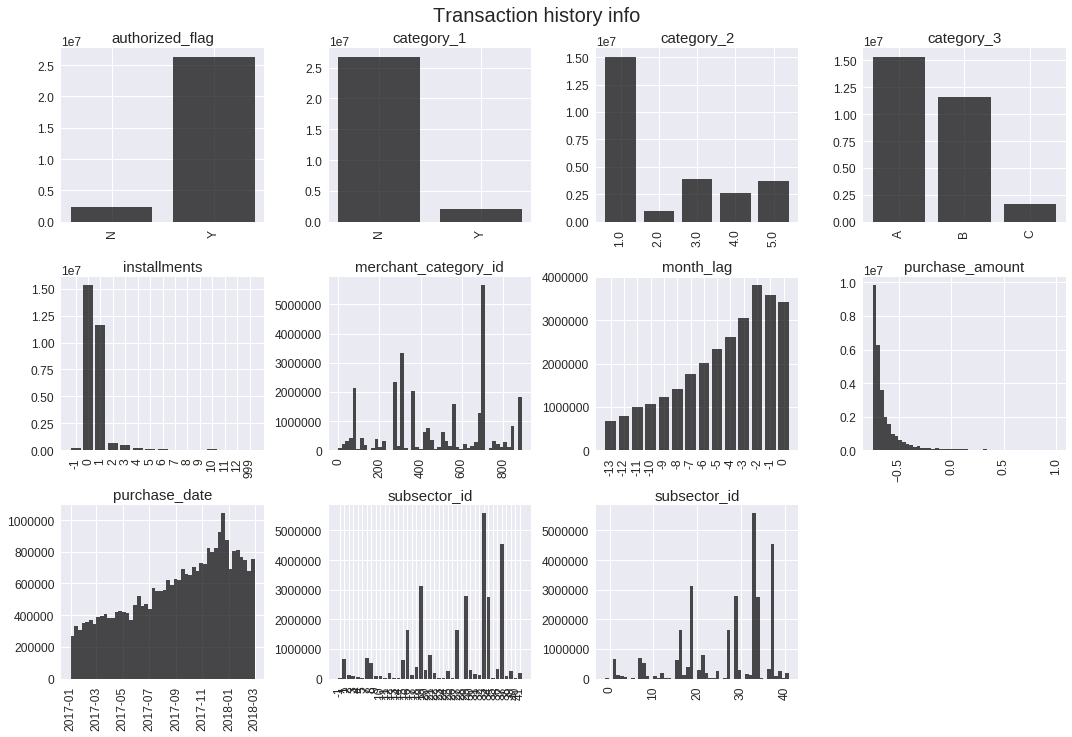

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.02, 'Transaction history info')

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'authorized_flag')

([0, 1], <a list of 2 Text xticklabel objects>)

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'category_1')

([0, 1], <a list of 2 Text xticklabel objects>)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'category_2')

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

<BarContainer object of 3 artists>

Text(0.5, 1.0, 'category_3')

([0, 1, 2], <a list of 3 Text xticklabel objects>)

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'installments')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

Text(0.5, 1.0, 'merchant_category_id')

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000.]),
 <a list of 7 Text xticklabel objects>)

<BarContainer object of 14 artists>

Text(0.5, 1.0, 'month_lag')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text xticklabel objects>)

Text(0.5, 1.0, 'purchase_amount')

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 <a list of 6 Text xticklabel objects>)

Text(0.5, 1.0, 'purchase_date')

(array([736330., 736389., 736450., 736511., 736573., 736634., 736695.,
        736754.]), <a list of 8 Text xticklabel objects>)

<BarContainer object of 41 artists>

Text(0.5, 1.0, 'subsector_id')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 <a list of 41 Text xticklabel objects>)

Text(0.5, 1.0, 'subsector_id')

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

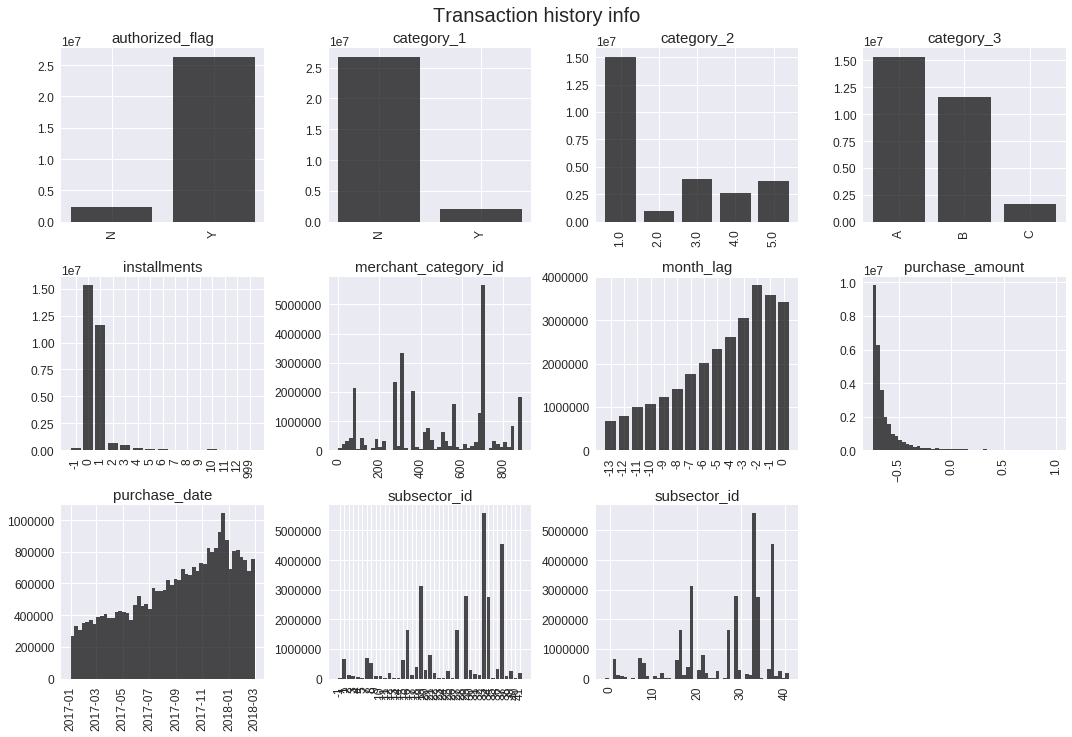

In [0]:
# drawing histograms for each column of filtered_trns_history
filtered_trns_history = transactions.loc[transactions['purchase_amount'] < 1]
cat_cols = ['authorized_flag', 'category_1', 'installments','category_3', 'month_lag','category_2', 'subsector_id']
num_cols = ['purchase_amount', 'purchase_date', 'merchant_category_id', 'subsector_id']

plt.figure(figsize=[15, 10])
plt.suptitle('Transaction history info', y=1.02, fontsize=20)
ncols = 4
nrows = int(np.ceil((len(cat_cols) + len(num_cols))/4))
last_ind = 0
for col in sorted(list(filtered_trns_history.columns)):
    #print('processing column ' + col)
    if col in cat_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = filtered_trns_history[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color=(0, 0, 0, 0.7))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    if col in num_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        filtered_trns_history[col].hist(bins = 50, color=(0, 0, 0, 0.7))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    plt.tight_layout()

#### Observations:
* unlike in new nerchants' transactions, some transactions here were not authorized
* installments column either has bugs or is normalized (since it contains -1 and 999 values)
* all transactions here were made before the reference date (month_lag <= 0)
* month lag has all negative values

In [0]:
# converting category_1, authorized_flag and category_3 values to numeric ones, so we can use then in scatter plots and correlation coefficients
filtered_trns_history['category_3'].replace({'A':0, 'B':1, 'C':2}, inplace=True)
filtered_trns_history['category_1'].replace({'N':0, 'Y':1}, inplace=True)
filtered_trns_history['authorized_flag'].replace({'N':0, 'Y':1}, inplace=True)

### 3.4.3 correlations between columns in historical_transactions

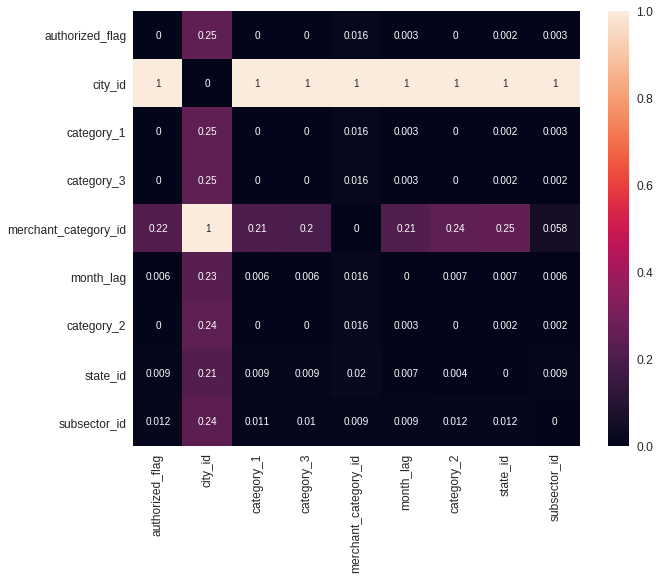

In [0]:
# correlations between columns in historical_transactions.csv:
cat_corr(transactions)

#### Observations:
1. city_id's are highly correlated with all the other features
2. Merchant_catergory_id's are fairly correlated with other features

## 3.5 Exploring Common card_id's between datasets

In [0]:
def isin(a,b):
    From = pd.DataFrame(a)
    To = pd.DataFrame(b)
    return(np.mean(From[0].isin(To[0]))*100)

#### 3.5.1. train.csv with the rest

In [0]:
print(isin(train["card_id"].unique(),test["card_id"].unique()), '% of unique credit cards from train.csv in test.csv')
print(isin(train["card_id"].unique(),transactions["card_id"].unique()), '% of unique credit cards from train.csv in historical_transactions.csv')
print(isin(train["card_id"].unique(),new_transactions["card_id"].unique()), '% of unique credit cards from train.csv in new_merchant_transactions.csv')

0.0 % of unique credit cards from train.csv in test.csv
100.0 % of unique credit cards from train.csv in historical_transactions.csv
89.13860645710862 % of unique credit cards from train.csv in new_merchant_transactions.csv


#### 3.5.2. test.csv with the rest

In [0]:
print(isin(test["card_id"].unique(),train["card_id"].unique()), '% of unique credit cards from test.csv in train.csv')
print(isin(test["card_id"].unique(),transactions["card_id"].unique()), '% of unique credit cards from test.csv in historical_transactions.csv')
print(isin(test["card_id"].unique(),new_transactions["card_id"].unique()), '% of unique credit cards from test.csv in new_merchant_transactions.csv')

0.0 % of unique credit cards from test.csv in train.csv
100.0 % of unique credit cards from test.csv in historical_transactions.csv
88.99233961317877 % of unique credit cards from test.csv in new_merchant_transactions.csv


#### 3.5.3. historical_transactions.csv with the rest

In [0]:
print(isin(transactions["card_id"].unique(),new_transactions["card_id"].unique()), '% of unique credit cards from historical_transactions.csv in new_merchant_transactions.csv')
print(isin(transactions["merchant_id"].unique(),merchants["merchant_id"].unique()), '% of unique merchants from historical_transactions.csv in merchants.csv')
print(isin(new_transactions["merchant_id"].unique(),merchants["merchant_id"].unique()), '% of unique merchants from new_merchant_transactions.csv in merchants.csv')

89.08306198931007 % of unique credit cards from historical_transactions.csv in new_merchant_transactions.csv
99.99969354482826 % of unique merchants from historical_transactions.csv in merchants.csv
99.99955777650025 % of unique merchants from new_merchant_transactions.csv in merchants.csv


#### 3.5.4. Number of Duplicates

In [0]:
#Duplicated IDs in merchants.csv

tmp = merchants.drop_duplicates()
print('Number of duplicates in merchants.csv using all features:',merchants.shape[0]-tmp.shape[0])

tmp = merchants.drop_duplicates(subset=["merchant_id","merchant_category_id","subsector_id"])
print('Number of duplicates in merchants.csv using the ID features merchant_id, merchant_category_id, subsector_id:',merchants.shape[0]-tmp.shape[0])

tmp = merchants.drop_duplicates(subset="merchant_id")
print('Number of duplicates in merchants.csv using only ID feature merchant_id', merchants.shape[0]-tmp.shape[0])

tmp = merchants.drop_duplicates(subset=["merchant_id","merchant_group_id","merchant_category_id",
                                        "subsector_id","city_id","state_id"])
print('Number of duplicates in merchants.csv using all ID features merchant_id, merchant_group_id, merchant_category_id, subsector_id, city_id",state_id*', merchants.shape[0]-tmp.shape[0])

tmp = merchants.drop_duplicates(subset=["merchant_id","merchant_group_id","merchant_category_id", "subsector_id"])
print('Number of duplicates in merchants.csv using the ID features merchant_id, merchant_group_id, merchant_category_id, subsector_id', merchants.shape[0]-tmp.shape[0])

Number of duplicates in merchants.csv using all features: 0
nNumber of duplicates in merchants.csv using the ID features merchant_id, merchant_category_id, subsector_id: 62
Number of duplicates in merchants.csv using only ID feature merchant_id 63
Number of duplicates in merchants.csv using all ID features merchant_id, merchant_group_id, merchant_category_id, subsector_id, city_id",state_id* 51
Number of duplicates in merchants.csv using the ID features merchant_id, merchant_group_id, merchant_category_id, subsector_id 51
